# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

In [2]:
import pandas as pd
import numpy as np

In [3]:
print(x_train_pics.shape)
print(y_train.shape)
print(x_train.shape)

(60000, 28, 28)
(60000,)
(60000, 784)


Немного о данных, с которыми предстоит работать:

1.  x_train_pics - 3D массив изображений 
2.  x_train - развернутый в матрицу x_train_pics (каждая строка - развернутое 28x28 изображение)
3.  y_train - массив меток классов

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn import decomposition, preprocessing, svm, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        if classifier not in ['svm', 'logreg']:
            raise ValueError('Incorrect classifier')
        else:
            self.classifier = classifier
    
    def __PCA(self, X, train=True) -> np.ndarray:
        if train:
            self.pca = decomposition.PCA(n_components=self.new_dim)
            self.pca.fit(X)            
        X_decomposed = self.pca.transform(X)
        return X_decomposed

    def __sigma(self, X, subset_size=1000000) -> float:
        X_dim = X.shape
        if X_dim[0] * X_dim[1] < 2 * subset_size:
            subset_rows = X_dim[0] // 2
        else:
            subset_rows = subset_size // X_dim[1]
        
        X_new = np.array(X)
        np.random.shuffle(X_new)
        eval_subset = X_new[:(2 * subset_rows)]
        eval_subset_one = eval_subset[:subset_rows]
        eval_subset_two = eval_subset[subset_rows:(subset_rows * 2)]

        del eval_subset

        substract_squared = np.power((eval_subset_one - eval_subset_two), 2)
        for i in range(subset_rows):
            substract_squared[i] = substract_squared[i].sum()
        substract_squared = substract_squared[:, 0]
        median = np.median(substract_squared)
        # need a dot product of every row of substract_squared with I (Единичная матрица)
        # then reshape it to a vector and find median
        # BINGO!
        return median

    def __RFF(self, X, train=True):
        sigma_squared = self.__sigma(X)
        d = X.shape[1]
        if train:
            self.weights = np.random.normal(loc=0, scale=np.sqrt(1/sigma_squared), size=(self.n_features, d))
            self.bias = np.random.uniform(-np.pi, np.pi, size=(self.n_features, 1))

        X_RFF = np.cos( self.weights @ X.T + self.bias ).T
        if train:
            self.transformer = preprocessing.MinMaxScaler()
            self.transformer.fit(X_RFF)
        X_RFF = self.transformer.transform(X_RFF)
        
        # raise NotImplementedError
        return X_RFF

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.__PCA(X)
        else:
            X = preprocessing.scale(X)
        X_RFF = self.__RFF(X)

        # train_set = np.concatenate((y.T, X_RFF), axis=1)

        if self.classifier == 'svm':
            self.model = svm.SVC(kernel='linear',  max_iter = 10**4)
            # np.random.shuffle(train_set)
            
            self.model.fit(X_RFF, y)
        else:
            self.model = linear_model.LogisticRegression(max_iter = 10**3)
            # np.random.shuffle(train_set)
            
            self.model.fit(X_RFF, y)

        # raise NotImplementedError
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.__PCA(X, False)
        else:
            X = preprocessing.scale(X)
        X_RFF = self.__RFF(X, False)
        
        # raise NotImplementedError
        return self.model.predict_proba(X_RFF)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.classifier == 'svm':
            if self.use_PCA:
                X = self.__PCA(X, False)
            else:
                X = preprocessing.scale(X)
            X_RFF = self.__RFF(X, False)
            predictions = self.model.predict(X_RFF)
        else:
            probs = self.predict_proba(X)
            predictions = np.argmax(probs, axis = 1)
        # raise NotImplementedError
        return predictions
        

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.5,  random_state=126)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(30000, 784)
(30000, 784)
(30000,)
(30000,)


In [7]:
predictor = RFFPipeline(classifier='logreg', use_PCA=False, n_features=250)


predictor.fit(X_train, Y_train)

y_resulted = predictor.predict(X_test)

metrics.accuracy_score(Y_test, y_resulted)

0.8460666666666666

__ВАЖНЫЙ СЕБЕ УРОК__

Скейлить данные для линейных моделей!

In [8]:
predictor = RFFPipeline(classifier='svm')


predictor.fit(X_train, Y_train)

y_resulted = predictor.predict(X_test)

metrics.accuracy_score(Y_test, y_resulted)
# 88.4

c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.8803

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

_________

Попробую обучить на сырых и на отскейленых данных разные модели и посмотреть на результаты

In [8]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

# sklearn kernel svm 


In [9]:
# let's try raw svm on scaled and unscaled

X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)


model_linear = svm.SVC(kernel='linear',  max_iter = 10**4)
model_rbf = svm.SVC(kernel='rbf',  max_iter = 10**4)
model_logreg = linear_model.LogisticRegression(max_iter = 10**3)

In [10]:
# fit unscaled 

model_linear.fit(X_train, Y_train)
model_rbf.fit(X_train, Y_train)

pred_unscaled_lin = model_linear.predict(X_test)
pred_unscaled_rbf = model_rbf.predict(X_test)

print("Unscaled linear SVM accuracy :", metrics.accuracy_score(Y_test, pred_unscaled_lin))
print("Unscaled rbf SVM accuracy :", metrics.accuracy_score(Y_test, pred_unscaled_rbf))

c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Unscaled linear SVM accuracy : 0.7414333333333334
Unscaled rbf SVM accuracy : 0.8804333333333333


In [11]:
model_logreg.fit(X_train, Y_train)

pred_unscaled_logreg = model_logreg.predict(X_test)
# pred_unscaled_logreg = np.argmax(pred_unscaled_logreg, axis = 1)

print("Unscaled Logreg accuracy :", metrics.accuracy_score(Y_test, pred_unscaled_logreg))

Unscaled Logreg accuracy : 0.8281666666666667


c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# fit scaled

model_linear.fit(X_train_scaled, Y_train)
model_rbf.fit(X_train_scaled, Y_train)
model_logreg.fit(X_train_scaled, Y_train)

pred_scaled_lin = model_linear.predict(X_test_scaled)
pred_scaled_rbf = model_rbf.predict(X_test_scaled)

print("Scaled linear SVM accuracy :", metrics.accuracy_score(Y_test, pred_scaled_lin))
print("Scaled rbf SVM accuracy :", metrics.accuracy_score(Y_test, pred_scaled_rbf))

c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
pred_scaled_logreg = model_logreg.predict(X_test_scaled)
print("Scaled Logreg accuracy :", metrics.accuracy_score(Y_test, pred_scaled_logreg))

Scaled Logreg accuracy : 0.8313666666666667


Вылезли некоторые ошибки, потому что я не проверяю код перед запуском ахаха))

Но рассмотрим то, что получилось:

In [21]:
model_linreg_PCA = RFFPipeline(n_features=1000, classifier='logreg')
model_svm_PCA = RFFPipeline(n_features=1000, classifier='svm')

model_linreg = RFFPipeline(n_features=1000, classifier='logreg', use_PCA=False)
model_svm = RFFPipeline(n_features=1000, classifier='svm', use_PCA=False)

In [22]:
model_linreg_PCA.fit(X_train, Y_train)
model_svm_PCA.fit(X_train, Y_train)

c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RFFPipeline(classifier='svm')

In [23]:
model_linreg.fit(X_train, Y_train)
model_svm.fit(X_train, Y_train)

c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RFFPipeline(classifier='svm', use_PCA=False)

In [24]:
predict_linreg_PCA = model_linreg_PCA.predict(X_test)
predict_svm_PCA = model_svm_PCA.predict(X_test)

predict_linreg = model_linreg.predict(X_test)
predict_svm = model_svm.predict(X_test)

In [25]:
print("RFF SVM accuracy with PCA :", metrics.accuracy_score(Y_test, predict_svm_PCA))
print("RFF Logreg accuracy with PCA :", metrics.accuracy_score(Y_test, predict_linreg_PCA))
print("RFF SVM accuracy without PCA :", metrics.accuracy_score(Y_test, predict_svm))
print("RFF Logreg accuracy without PCA :", metrics.accuracy_score(Y_test, predict_linreg))

RFF SVM accuracy with PCA : 0.8804333333333333
RFF Logreg accuracy with PCA : 0.8802666666666666
RFF SVM accuracy without PCA : 0.8650333333333333
RFF Logreg accuracy without PCA : 0.8667333333333334


__UNSCALED RAW__

Unscaled linear SVM accuracy : 0.7414333333333334

Unscaled rbf SVM accuracy : 0.8804333333333333

Unscaled Logreg accuracy : 0.8293666666666667

__SCALED RAW__

Scaled linear SVM accuracy : 0.7573666666666666

Scaled rbf SVM accuracy : 0.8815

Scaled Logreg accuracy : 0.8313666666666667

__NEW FEATURES PCA (n_features = 250, new_dim = 50)__

RFF SVM accuracy with PCA : 0.8673

RFF Logreg accuracy with PCA : 0.8635333333333334

__NEW FEATURES NO PCA (n_features = 250)__

RFF SVM accuracy without PCA : 0.8473666666666667

RFF Logreg accuracy without PCA : 0.8429666666666666

__NEW FEATURES PCA (n_features = 1000, new_dim = 50)__

RFF SVM accuracy with PCA : 0.8804333333333333

RFF Logreg accuracy with PCA : 0.8802666666666666

__NEW FEATURES NO PCA (n_features = 1000)__

RFF SVM accuracy without PCA : 0.8650333333333333

RFF Logreg accuracy without PCA : 0.8667333333333334

Выводы? 

RFF + SVM очень похож по точности на RBF (radial basis function) SVM, что в целом и логично. Мы хорошо аппроксимируем ядро. По времени вроде все плюс минус одинаково. 
Забавно, что RFF + SVM дает такой же скор, как и unscaled RBF SVM, а наивысший скор у scaled RBF SVM

Чистый (линейный) SVM и со скейлингом и без него работает очень плохо в сравнении с другими методами. Сложно построить разделяющую гиперплоскость для таких данных. 

Сразу можно увидеть, что PCA позволяет немного, но улучшить модель, добившись лишних сотых. 
На удивление логрег с RFF работает столь же точно, как и SVM + RFF, без RFF разница сильно заметна.

Время для CatBoost!

In [27]:
import catboost as ctb
import sklearn

In [34]:
pca = decomposition.PCA(n_components=70)

pca.fit(X_train) 
X_train_PCA = pca.transform(X_train)

pca.fit(X_test) 
X_test_PCA = pca.transform(X_test)

In [35]:
model = ctb.CatBoostClassifier(verbose=1000)

param_grid = {
    'iterations' : [250, 500, 1000],
    'learning_rate' : [0.01, 0.05, 0.1]
}

clf = sklearn.model_selection.GridSearchCV(model, param_grid, scoring='accuracy')
clf.fit(X_train_PCA[:3000], Y_train[:3000])

clf.best_params

0:	learn: 2.2840427	total: 93ms	remaining: 23.2s
249:	learn: 0.8212714	total: 24.1s	remaining: 0us
0:	learn: 2.2816037	total: 98.3ms	remaining: 24.5s
249:	learn: 0.8357887	total: 23.6s	remaining: 0us
0:	learn: 2.2783356	total: 93.2ms	remaining: 23.2s
249:	learn: 0.8458624	total: 25.9s	remaining: 0us
0:	learn: 2.2812901	total: 93.3ms	remaining: 23.2s
249:	learn: 0.8272565	total: 23.4s	remaining: 0us
0:	learn: 2.2785091	total: 88.7ms	remaining: 22.1s
249:	learn: 0.8328208	total: 23.4s	remaining: 0us
0:	learn: 2.2114291	total: 91.3ms	remaining: 22.7s
249:	learn: 0.3360161	total: 23.1s	remaining: 0us
0:	learn: 2.1994584	total: 86.5ms	remaining: 21.5s
249:	learn: 0.3346184	total: 23.4s	remaining: 0us
0:	learn: 2.1834413	total: 89.1ms	remaining: 22.2s
249:	learn: 0.3419344	total: 23.3s	remaining: 0us
0:	learn: 2.1978514	total: 89.6ms	remaining: 22.3s
249:	learn: 0.3314665	total: 23.4s	remaining: 0us
0:	learn: 2.1840822	total: 91.9ms	remaining: 22.9s
249:	learn: 0.3228771	total: 23.2s	remaini

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [38]:
clf.best_params_

{'iterations': 1000, 'learning_rate': 0.1}

In [40]:
model = ctb.CatBoostClassifier(iterations=1000, learning_rate=0.1, verbose=700)
model.fit(X_train_PCA, Y_train)

0:	learn: 1.9643246	total: 188ms	remaining: 3m 7s
700:	learn: 0.1771013	total: 2m 24s	remaining: 1m 1s
999:	learn: 0.1342620	total: 3m 21s	remaining: 0us


In [41]:
catboost_prediction = model.predict(X_test_PCA)

print("GB accuracy with PCA (new_dim = 70):", metrics.accuracy_score(Y_test, catboost_prediction))

GB accuracy with PCA (new_dim = 70): 0.3584333333333333


Бустинг дал слишком низкий скор, это может быть связано с маленьким количеством фич после PCA, или с чем либо другим, времени проверить досконально не остается:(

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Создадим сразу несколько моделей и протестируем их accuracy score

In [10]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

# Протестируем влияние разного количеств фич на SVM 
model_svm_100 = RFFPipeline(classifier='svm', n_features=100)
model_svm_500 = RFFPipeline(classifier='svm', n_features=500)

model_svm_100.fit(X_train, Y_train)
model_svm_500.fit(X_train, Y_train)

y_100 = model_svm_100.predict(X_test)
y_500 = model_svm_500.predict(X_test)

print("n_features = 100 ",metrics.accuracy_score(Y_test, y_100))
print("n_features = 500 ",metrics.accuracy_score(Y_test, y_500))

c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


n_features = 100  0.8548333333333333
n_features = 500  0.8782916666666667


In [11]:
model_svm_2000 = RFFPipeline(classifier='svm', n_features=2000)
model_svm_2000.fit(X_train, Y_train)

y_2000 = model_svm_2000.predict(X_test)

print("n_features = 2000 ",metrics.accuracy_score(Y_test, y_2000))

c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


n_features = 2000  0.88


In [8]:
n_features_array = [100, 250, 500, 1000, 1250, 1700, 2000]
classifier_array = ['svm', 'logreg']

svm_accuracy = []
logreg_accuracy = []

for element_1 in n_features_array:
    for element_2 in classifier_array:
        print("classifier: ", element_2, '\n', 'n_features: ', element_1)
        model = RFFPipeline(classifier=element_2, n_features=element_1)
        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        accuracy = metrics.accuracy_score(Y_test, prediction)
        if element_2 == 'svm':
            svm_accuracy.append(accuracy)
        else:
            logreg_accuracy.append(accuracy)

print(svm_accuracy)
print(logreg_accuracy)

classifier:  svm 
 n_features:  100


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  100


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  500


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  500


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  1000


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  1000


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  1250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  1250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  1700


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  1700


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 n_features:  2000


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 n_features:  2000


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.8543333333333333, 0.873375, 0.8784583333333333, 0.8829166666666667, 0.883875, 0.8776666666666667, 0.8814583333333333]
[0.8435833333333334, 0.8669583333333334, 0.8745416666666667, 0.8797916666666666, 0.8830833333333333, 0.887375, 0.8883333333333333]


In [32]:
n_features_array = [100, 250, 500, 1000, 1250, 1700, 2000]
svm_accuracy = [0.8543333333333333, 0.873375, 0.8784583333333333, 0.8829166666666667, 0.883875, 0.8776666666666667, 0.8814583333333333]
logreg_accuracy = [0.8435833333333334, 0.8669583333333334, 0.8745416666666667, 0.8797916666666666, 0.8830833333333333, 0.887375, 0.8883333333333333]

In [43]:
accuracy_data = np.array([n_features_array, svm_accuracy, logreg_accuracy]).T

accuracy_data = pd.DataFrame(accuracy_data, columns=['n_features', 'svm', 'logreg'])

In [44]:
accuracy_data

,n_features,svm,logreg
0,100.0,0.854333,0.843583
1,250.0,0.873375,0.866958
2,500.0,0.878458,0.874542
3,1000.0,0.882917,0.879792
4,1250.0,0.883875,0.883083
5,1700.0,0.877667,0.887375
6,2000.0,0.881458,0.888333


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

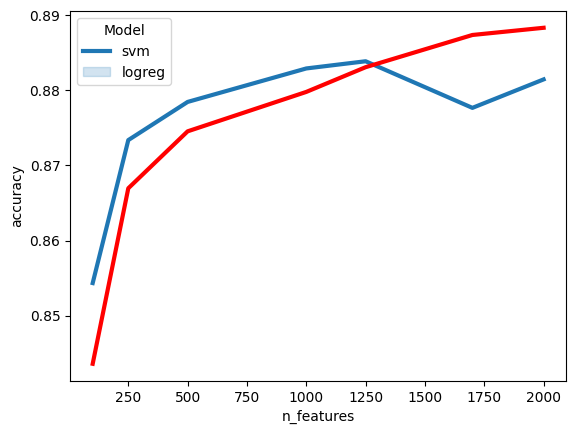

In [36]:
sns.lineplot(x='n_features',
            y='svm',
            data=accuracy_data,
            #label='svm',
            lw=3)
sns.lineplot(x='n_features',
            y='logreg',
            data=accuracy_data,
            color='r',
            #label='logreg',
            lw=3)

plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.legend(labels=['svm', 'logreg'] ,title='Model')


__Ремарка__

Я не рискнул тестировать на n_features более 2000, так как время выполнения уже на 2000 тысячах превышает 20 минут. 

Однако, на данной выборке параметров n_features видно резкий подъем где-то до 1250 фич, а дальше плюс минус стабильно

Теперь попробую поменять значения PCA разложения с константным количеством n_features (250)

In [9]:
pca_array = [50, 75, 100, 250, 400]
classifier_array = ['svm', 'logreg']

svm_PCA_accuracy = []
logreg_PCA_accuracy = []

for element_1 in pca_array:
    for element_2 in classifier_array:
        print("classifier: ", element_2, '\n', 'new_dim: ', element_1)
        model = RFFPipeline(classifier=element_2, n_features=250, new_dim=element_1)
        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        accuracy = metrics.accuracy_score(Y_test, prediction)
        if element_2 == 'svm':
            svm_PCA_accuracy.append(accuracy)
        else:
            logreg_PCA_accuracy.append(accuracy)

print(svm_PCA_accuracy)
print(logreg_PCA_accuracy)

classifier:  svm 
 new_dim:  50


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 new_dim:  50


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 new_dim:  75


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 new_dim:  75


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 new_dim:  100


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 new_dim:  100


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 new_dim:  250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 new_dim:  250


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classifier:  svm 
 new_dim:  400


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


classifier:  logreg 
 new_dim:  400


c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.8690416666666667, 0.872125, 0.870625, 0.863375, 0.8605]
[0.865, 0.8654583333333333, 0.8643333333333333, 0.8572916666666667, 0.8507916666666666]


In [57]:
pca_array = [50, 75, 100, 250, 400]

svm_PCA_accuracy = [0.8690416666666667, 0.872125, 0.870625, 0.863375, 0.8605]
logreg_PCA_accuracy = [0.865, 0.8654583333333333, 0.8643333333333333, 0.8572916666666667, 0.8507916666666666]

In [59]:
accuracy_data_pca = np.array([pca_array, svm_PCA_accuracy, logreg_PCA_accuracy]).T

accuracy_data_pca = pd.DataFrame(accuracy_data_pca, columns=['pca', 'svm', 'logreg'])
accuracy_data_pca

,pca,svm,logreg
0,50.0,0.869042,0.865000
1,75.0,0.872125,0.865458
2,100.0,0.870625,0.864333
3,250.0,0.863375,0.857292
4,400.0,0.860500,0.850792


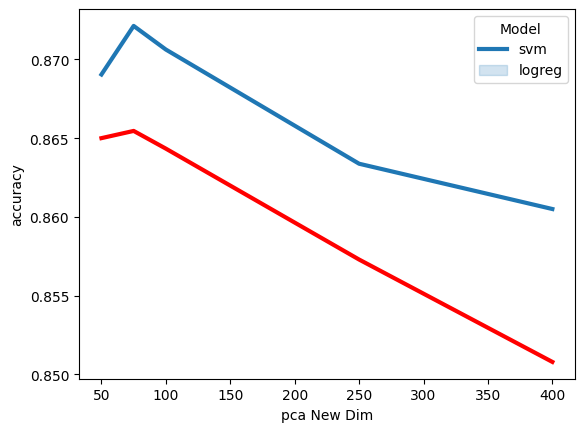

In [60]:
sns.lineplot(x='pca',
            y='svm',
            data=accuracy_data_pca,
            #label='svm',
            lw=3)
sns.lineplot(x='pca',
            y='logreg',
            data=accuracy_data_pca,
            color='r',
            #label='logreg',
            lw=3)

plt.xlabel('pca New Dim')
plt.ylabel('accuracy')
plt.legend(labels=['svm', 'logreg'] ,title='Model')

Можно заметить, что у обоих моделей максимальная точность получается на разложении в примерно 70, далее точность падает

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline_var_funcs(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, func='cos', classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        func, string: 'cos', 'sin', 'exp', 'tanh', 'sigmoid', 'sign', 'None'

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        if func not in ['cos', 'sin', 'exp', 'tanh', 'sigmoid', 'sign', 'None']:
            raise ValueError('Incorrect function')
        else:
            self.func = func

        if classifier not in ['svm', 'logreg']:
            raise ValueError('Incorrect classifier')
        else:
            self.classifier = classifier
    
    def __PCA(self, X, train=True) -> np.ndarray:
        if train:
            self.pca = decomposition.PCA(n_components=self.new_dim)
            self.pca.fit(X)            
        X_decomposed = self.pca.transform(X)
        return X_decomposed

    def __sigma(self, X, subset_size=1000000) -> float:
        X_dim = X.shape
        if X_dim[0] * X_dim[1] < 2 * subset_size:
            subset_rows = X_dim[0] // 2
        else:
            subset_rows = subset_size // X_dim[1]
        
        X_new = np.array(X)
        np.random.shuffle(X_new)
        eval_subset = X_new[:(2 * subset_rows)]
        eval_subset_one = eval_subset[:subset_rows]
        eval_subset_two = eval_subset[subset_rows:(subset_rows * 2)]
        del eval_subset

        substract_squared = np.power((eval_subset_one - eval_subset_two), 2)
        for i in range(subset_rows):
            substract_squared[i] = substract_squared[i].sum()
        median = np.median(substract_squared)

        return median

    def __RFF(self, X, train=True): 
        def sigmoid(x) -> np.float32:
            return 1 / (1 + np.exp(-x))

        sigma_squared = self.__sigma(X)
        d = X.shape[1]
        if train:
            self.weights = np.random.normal(loc=0, scale=np.sqrt(1/sigma_squared), size=(self.n_features, d))
            self.bias = np.random.uniform(-np.pi, np.pi, size=(self.n_features, 1))

        match self.func:
            case 'cos':
                X_RFF = np.cos( self.weights @ X.T + self.bias ).T
            case 'sin':
                X_RFF = np.sin( self.weights @ X.T + self.bias ).T
            case 'exp':
                X_RFF = np.exp( self.weights @ X.T + self.bias ).T
            case 'tanh':
                X_RFF = np.tanh( self.weights @ X.T + self.bias ).T
            case 'sigmoid':
                X_RFF = sigmoid( self.weights @ X.T + self.bias ).T
            case 'sign':
                X_RFF = np.sign( self.weights @ X.T + self.bias ).T
            case 'None':
                X_RFF = ( self.weights @ X.T + self.bias ).T
        
        # print(X_RFF)
        if train:
            self.transformer = preprocessing.MinMaxScaler()
            self.transformer.fit(X_RFF)
        X_RFF = self.transformer.transform(X_RFF)
        
        return X_RFF

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            X = self.__PCA(X)
        X_RFF = self.__RFF(X)
        if self.classifier == 'svm':
            self.model = svm.SVC(kernel='linear',  max_iter = 10**4)
            self.model.fit(X_RFF, y)
        else:
            self.model = linear_model.LogisticRegression(max_iter = 10**3)
            self.model.fit(X_RFF, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.__PCA(X, False)
        X_RFF = self.__RFF(X, False)
        
        return self.model.predict_proba(X_RFF)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.classifier == 'svm':
            if self.use_PCA:
                X = self.__PCA(X, False)
            X_RFF = self.__RFF(X, False)
            predictions = self.model.predict(X_RFF)
        else:
            probs = self.predict_proba(X)
            predictions = np.argmax(probs, axis = 1)

        return predictions
        

In [8]:
func_array = ['cos', 'sin', 'exp', 'tanh', 'sigmoid', 'sign', 'None']
classifier_array = ['svm', 'logreg']

svm_func_accuracy = []
logreg_func_accuracy = []

for element_1 in classifier_array:
    for element_2 in func_array:
        model = RFFPipeline_var_funcs(n_features=250, func=element_2, classifier=element_1)
        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        accuracy = metrics.accuracy_score(Y_test, prediction)
        if element_1 == 'svm':
            svm_func_accuracy.append(accuracy)
        else:
            logreg_func_accuracy.append(accuracy)

print(svm_func_accuracy)
print(logreg_func_accuracy)

c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\maxxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.8702083333333334, 0.8704583333333333, 0.858625, 0.8649166666666667, 0.863125, 0.7840833333333334, 0.8479166666666667]
[0.8647083333333333, 0.8627083333333333, 0.8505416666666666, 0.8579583333333334, 0.8539166666666667, 0.7932083333333333, 0.8355]


In [15]:
svm_func_accuracy = [0.8702083333333334, 0.8704583333333333, 0.858625, 0.8649166666666667, 0.863125, 0.7840833333333334, 0.8479166666666667]
logreg_func_accuracy = [0.8647083333333333, 0.8627083333333333, 0.8505416666666666, 0.8579583333333334, 0.8539166666666667, 0.7932083333333333, 0.8355]

accuracy_data_func = np.array([func_array, svm_func_accuracy, logreg_func_accuracy]).T

accuracy_data_func = pd.DataFrame(accuracy_data_pca, columns=['function', 'svm', 'logreg'])

,function,svm,logreg
0,cos,0.8702083333333334,0.8647083333333333
1,sin,0.8704583333333333,0.8627083333333333
2,exp,0.858625,0.8505416666666666
3,tanh,0.8649166666666667,0.8579583333333334
4,sigmoid,0.863125,0.8539166666666667
5,sign,0.7840833333333334,0.7932083333333333
6,None,0.8479166666666667,0.8355


In [81]:
func_double = func_array * 2
ans_array = svm_func_accuracy + logreg_func_accuracy
solv_array = ['svm'] * 7 + ['logreg'] * 7

accuracy_data_func_new = np.array([func_double, ans_array, solv_array]).T
accuracy_data_func_new = pd.DataFrame(accuracy_data_func_new, columns=['function', 'score', 'solver'])

accuracy_data_func_new['score'] = pd.to_numeric(accuracy_data_func_new['score'])
accuracy_data_func_new

,function,score,solver
0,cos,0.870208,svm
1,sin,0.870458,svm
2,exp,0.858625,svm
3,tanh,0.864917,svm
4,sigmoid,0.863125,svm
5,sign,0.784083,svm
6,None,0.847917,svm
7,cos,0.864708,logreg
8,sin,0.862708,logreg
9,exp,0.850542,logreg


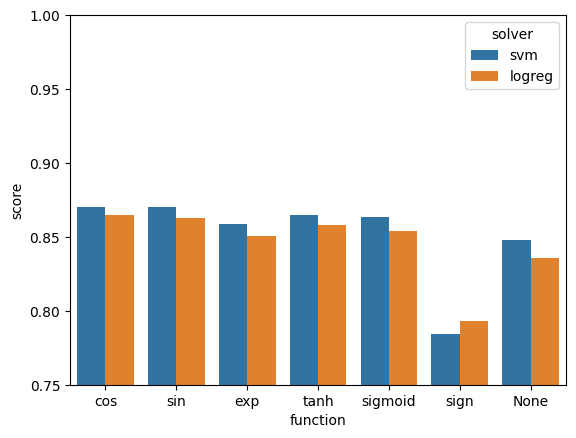

In [84]:
sns.barplot(
    data=accuracy_data_func_new,
    x='function',
    y='score',
    hue='solver'
)
plt.ylim(0.75, 1.0);

Как можно видеть, нет большой разницы в том, какую функцию использовать (только на sign имеется некоторая просадка). Это можно связать с тем, что PCA очень хорошо преобразует фичи, понижая в некоторой степени разряженные данные картинок в плотный вектор размера new_Dim.

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError

In [22]:
def difference(array, need, count):
    counter = 0
    final_array = [need]
    while (need in array) and (counter != count):
        final_array.append(need)
        array.pop(array.index(need))
        counter += 1

    if counter >= count:
        return 0

    while counter < count:
        step_min = min(final_array)
        step_max = max(final_array)
        potential_min = min(array, key=lambda x: abs(x - step_min))
        potential_max = min(array, key=lambda x: abs(x - step_max))
        print(step_min, step_max)
        print(potential_min, potential_max)
        print('\n')
        if potential_max - step_min < step_max - potential_min:
            array.pop(array.index(potential_max))
            final_array.append(potential_max)
        else:
            array.pop(array.index(potential_min))
            final_array.append(potential_min)
        counter += 1
    return max(final_array) - min(final_array)


In [23]:
difference([3, 7, 9, 10], 5, 3)

5 5
3 3


3 5
7 7


3 7
9 9




6